In [1]:
import numpy as np
from tqdm import trange

from kuramoto import Kuramoto
from kuramoto.db_metrics import *

from NNetwork import NNetwork as nn
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import svm
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency

import warnings
warnings.filterwarnings("ignore")

## Plotting Functions

#### 1. Display Graphs

In [2]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

#### 2. Display Dictionaries

In [3]:
def display_dictionary(W, dictionary_shape=None ,save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    
    if dictionary_shape is None:
        k = int(np.sqrt(W.shape[0]))
        dict_shape = (k,k)
    else:
        dict_shape = dictionary_shape
        
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

#### 3. Display both Graphs and Dictionaries

In [4]:
def display_dict_and_graph(title,
                           W,
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

## NMF Functions

In [5]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

## Dictionary Plotting Functions

In [70]:
def generate_nxg(get_patches_X):
    
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(50,50)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

def synchronization(colors):
    ordered = list(np.pi - colors); ordered.sort()
    lordered = len(ordered)
    
    threshold = np.pi
    if ordered == 0:
        assert("Empty array or logic error.")
    elif lordered == 1:
        return (0 < threshold)
    elif lordered == 2:
        dw = ordered[1]-ordered[0]
        if dw > threshold:
            return ((2*np.pi - dw) < threshold)
        else:
            return (dw < threshold)
    else:
        widths = [2*np.pi+ordered[0]-ordered[-1]]
        for i in range(lordered-1):
            widths.append(ordered[i+1]-ordered[i])
        return (np.abs(2*np.pi - max(widths)) < threshold)

## Network Sampling - UCLA

In [67]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


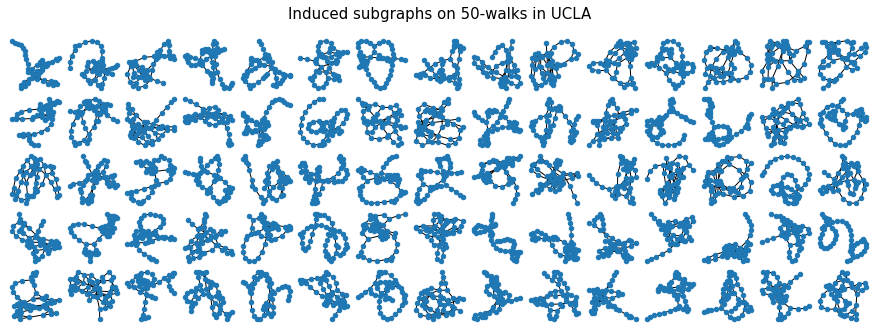

In [68]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [95]:
W, H = ALS(X=X, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  0%|▏                                   | 5/1000 [00:00<00:55, 17.78it/s]

iteration 0, reconstruction error 394901.851706


  2%|▌                                  | 15/1000 [00:00<00:50, 19.41it/s]

iteration 10, reconstruction error 154780.586986


  2%|▊                                  | 24/1000 [00:01<00:48, 20.22it/s]

iteration 20, reconstruction error 160602.025835


  3%|█▏                                 | 33/1000 [00:01<00:49, 19.56it/s]

iteration 30, reconstruction error 168309.093655


  4%|█▌                                 | 45/1000 [00:02<00:48, 19.69it/s]

iteration 40, reconstruction error 169053.810166


  5%|█▊                                 | 53/1000 [00:02<00:47, 20.04it/s]

iteration 50, reconstruction error 168938.460190


  6%|██▏                                | 64/1000 [00:03<00:47, 19.56it/s]

iteration 60, reconstruction error 168573.037343


  7%|██▌                                | 73/1000 [00:03<00:46, 19.80it/s]

iteration 70, reconstruction error 167701.395110


  8%|██▊                                | 82/1000 [00:04<00:47, 19.22it/s]

iteration 80, reconstruction error 165737.300386


  9%|███▎                               | 94/1000 [00:04<00:48, 18.54it/s]

iteration 90, reconstruction error 161612.979464


 10%|███▌                              | 105/1000 [00:05<00:45, 19.57it/s]

iteration 100, reconstruction error 154074.362193


 11%|███▉                              | 114/1000 [00:05<00:47, 18.85it/s]

iteration 110, reconstruction error 143729.350773


 12%|████▏                             | 124/1000 [00:06<00:44, 19.54it/s]

iteration 120, reconstruction error 136976.615933


 13%|████▌                             | 133/1000 [00:06<00:45, 18.87it/s]

iteration 130, reconstruction error 134928.292994


 14%|████▉                             | 144/1000 [00:07<00:45, 18.66it/s]

iteration 140, reconstruction error 133421.326608


 15%|█████▏                            | 153/1000 [00:07<00:48, 17.61it/s]

iteration 150, reconstruction error 132056.103953


 16%|█████▌                            | 164/1000 [00:08<00:44, 18.96it/s]

iteration 160, reconstruction error 130884.740957


 17%|█████▉                            | 174/1000 [00:09<00:43, 18.91it/s]

iteration 170, reconstruction error 129966.331167


 18%|██████▏                           | 183/1000 [00:09<00:51, 15.90it/s]

iteration 180, reconstruction error 129284.549229


 19%|██████▌                           | 193/1000 [00:10<00:46, 17.48it/s]

iteration 190, reconstruction error 128785.400651


 20%|██████▉                           | 204/1000 [00:10<00:47, 16.76it/s]

iteration 200, reconstruction error 128416.966460


 21%|███████▏                          | 213/1000 [00:11<00:43, 18.30it/s]

iteration 210, reconstruction error 128140.452339


 22%|███████▌                          | 224/1000 [00:11<00:41, 18.80it/s]

iteration 220, reconstruction error 127929.746825


 23%|███████▉                          | 233/1000 [00:12<00:41, 18.34it/s]

iteration 230, reconstruction error 127766.200368


 24%|████████▎                         | 244/1000 [00:12<00:39, 19.03it/s]

iteration 240, reconstruction error 127636.769868


 26%|████████▋                         | 255/1000 [00:13<00:37, 19.63it/s]

iteration 250, reconstruction error 127532.328066


 26%|████████▉                         | 263/1000 [00:13<00:38, 18.94it/s]

iteration 260, reconstruction error 127446.757599


 27%|█████████▎                        | 274/1000 [00:14<00:39, 18.45it/s]

iteration 270, reconstruction error 127375.254812


 28%|█████████▌                        | 283/1000 [00:15<00:40, 17.83it/s]

iteration 280, reconstruction error 127314.634119


 29%|█████████▉                        | 293/1000 [00:15<00:37, 18.83it/s]

iteration 290, reconstruction error 127262.237302


 30%|██████████▎                       | 303/1000 [00:16<00:37, 18.43it/s]

iteration 300, reconstruction error 127216.213928


 31%|██████████▋                       | 314/1000 [00:16<00:36, 18.57it/s]

iteration 310, reconstruction error 127175.131397


 32%|███████████                       | 324/1000 [00:17<00:36, 18.44it/s]

iteration 320, reconstruction error 127138.047480


 33%|███████████▎                      | 334/1000 [00:17<00:39, 16.89it/s]

iteration 330, reconstruction error 127104.218022


 34%|███████████▋                      | 344/1000 [00:18<00:35, 18.57it/s]

iteration 340, reconstruction error 127073.083347


 35%|████████████                      | 353/1000 [00:18<00:34, 18.64it/s]

iteration 350, reconstruction error 127044.218204


 36%|████████████▍                     | 364/1000 [00:19<00:33, 18.82it/s]

iteration 360, reconstruction error 127017.301467


 37%|████████████▋                     | 374/1000 [00:19<00:32, 19.21it/s]

iteration 370, reconstruction error 126992.044834


 38%|█████████████                     | 383/1000 [00:20<00:32, 18.77it/s]

iteration 380, reconstruction error 126968.197722


 40%|█████████████▍                    | 395/1000 [00:21<00:32, 18.62it/s]

iteration 390, reconstruction error 126945.562931


 40%|█████████████▋                    | 403/1000 [00:21<00:33, 17.99it/s]

iteration 400, reconstruction error 126923.966344


 41%|██████████████                    | 413/1000 [00:22<00:32, 17.99it/s]

iteration 410, reconstruction error 126903.255955


 42%|██████████████▍                   | 423/1000 [00:22<00:30, 18.66it/s]

iteration 420, reconstruction error 126883.304391


 43%|██████████████▊                   | 434/1000 [00:23<00:29, 18.96it/s]

iteration 430, reconstruction error 126864.049966


 44%|███████████████                   | 444/1000 [00:23<00:28, 19.67it/s]

iteration 440, reconstruction error 126845.425366


 45%|███████████████▍                  | 454/1000 [00:24<00:30, 18.19it/s]

iteration 450, reconstruction error 126827.358810


 46%|███████████████▋                  | 463/1000 [00:24<00:28, 18.84it/s]

iteration 460, reconstruction error 126809.747749


 47%|████████████████                  | 474/1000 [00:25<00:26, 19.64it/s]

iteration 470, reconstruction error 126792.534484


 48%|████████████████▍                 | 483/1000 [00:25<00:30, 16.73it/s]

iteration 480, reconstruction error 126775.669952


 49%|████████████████▋                 | 492/1000 [00:26<00:27, 18.26it/s]

iteration 490, reconstruction error 126759.121490


 50%|█████████████████                 | 503/1000 [00:26<00:26, 18.77it/s]

iteration 500, reconstruction error 126742.844912


 51%|█████████████████▍                | 514/1000 [00:27<00:28, 17.09it/s]

iteration 510, reconstruction error 126726.800399


 52%|█████████████████▊                | 524/1000 [00:28<00:26, 17.94it/s]

iteration 520, reconstruction error 126710.992342


 53%|██████████████████                | 533/1000 [00:28<00:25, 18.12it/s]

iteration 530, reconstruction error 126695.385850


 54%|██████████████████▍               | 543/1000 [00:29<00:24, 18.82it/s]

iteration 540, reconstruction error 126680.004965


 56%|██████████████████▊               | 555/1000 [00:29<00:23, 19.32it/s]

iteration 550, reconstruction error 126664.850734


 56%|███████████████████▏              | 564/1000 [00:30<00:23, 18.17it/s]

iteration 560, reconstruction error 126649.891035


 57%|███████████████████▍              | 573/1000 [00:30<00:23, 18.46it/s]

iteration 570, reconstruction error 126635.067563


 58%|███████████████████▊              | 584/1000 [00:31<00:21, 19.51it/s]

iteration 580, reconstruction error 126620.335516


 60%|████████████████████▏             | 595/1000 [00:31<00:20, 20.10it/s]

iteration 590, reconstruction error 126605.665065


 60%|████████████████████▌             | 603/1000 [00:32<00:20, 19.18it/s]

iteration 600, reconstruction error 126591.030871


 61%|████████████████████▉             | 614/1000 [00:32<00:20, 18.69it/s]

iteration 610, reconstruction error 126576.399337


 62%|█████████████████████▏            | 624/1000 [00:33<00:22, 16.42it/s]

iteration 620, reconstruction error 126561.744082


 63%|█████████████████████▌            | 634/1000 [00:34<00:21, 16.95it/s]

iteration 630, reconstruction error 126547.055661


 64%|█████████████████████▉            | 644/1000 [00:34<00:23, 15.04it/s]

iteration 640, reconstruction error 126532.324277


 65%|██████████████████████▏           | 654/1000 [00:35<00:21, 15.93it/s]

iteration 650, reconstruction error 126517.548402


 66%|██████████████████████▌           | 664/1000 [00:35<00:18, 18.23it/s]

iteration 660, reconstruction error 126502.708457


 67%|██████████████████████▉           | 673/1000 [00:36<00:17, 18.91it/s]

iteration 670, reconstruction error 126487.779915


 68%|███████████████████████▏          | 683/1000 [00:36<00:17, 18.38it/s]

iteration 680, reconstruction error 126472.759047


 70%|███████████████████████▋          | 695/1000 [00:37<00:15, 19.45it/s]

iteration 690, reconstruction error 126457.622890


 70%|███████████████████████▉          | 703/1000 [00:37<00:16, 17.97it/s]

iteration 700, reconstruction error 126442.375978


 71%|████████████████████████▏         | 713/1000 [00:38<00:14, 19.17it/s]

iteration 710, reconstruction error 126427.021241


 72%|████████████████████████▌         | 724/1000 [00:39<00:14, 18.79it/s]

iteration 720, reconstruction error 126411.581196


 73%|████████████████████████▉         | 734/1000 [00:39<00:15, 17.51it/s]

iteration 730, reconstruction error 126396.042392


 74%|█████████████████████████▎        | 744/1000 [00:40<00:14, 17.97it/s]

iteration 740, reconstruction error 126380.416383


 75%|█████████████████████████▋        | 754/1000 [00:40<00:13, 18.16it/s]

iteration 750, reconstruction error 126364.722191


 76%|█████████████████████████▉        | 764/1000 [00:41<00:13, 17.17it/s]

iteration 760, reconstruction error 126348.993545


 78%|██████████████████████████▎       | 775/1000 [00:41<00:12, 18.66it/s]

iteration 770, reconstruction error 126333.254772


 78%|██████████████████████████▋       | 784/1000 [00:42<00:11, 18.86it/s]

iteration 780, reconstruction error 126317.539406


 79%|██████████████████████████▉       | 793/1000 [00:42<00:11, 18.74it/s]

iteration 790, reconstruction error 126301.880521


 80%|███████████████████████████▎      | 805/1000 [00:43<00:09, 19.86it/s]

iteration 800, reconstruction error 126286.326185


 82%|███████████████████████████▋      | 815/1000 [00:44<00:09, 18.74it/s]

iteration 810, reconstruction error 126270.909593


 82%|████████████████████████████      | 824/1000 [00:44<00:09, 18.27it/s]

iteration 820, reconstruction error 126255.672220


 83%|████████████████████████████▎     | 833/1000 [00:44<00:09, 18.49it/s]

iteration 830, reconstruction error 126240.671517


 84%|████████████████████████████▋     | 842/1000 [00:45<00:08, 18.40it/s]

iteration 840, reconstruction error 126225.955941


 85%|█████████████████████████████     | 853/1000 [00:46<00:08, 18.34it/s]

iteration 850, reconstruction error 126211.553587


 86%|█████████████████████████████▍    | 864/1000 [00:46<00:06, 19.48it/s]

iteration 860, reconstruction error 126197.500127


 87%|█████████████████████████████▋    | 873/1000 [00:47<00:06, 18.69it/s]

iteration 870, reconstruction error 126183.825293


 88%|██████████████████████████████    | 883/1000 [00:47<00:06, 18.33it/s]

iteration 880, reconstruction error 126170.549180


 89%|██████████████████████████████▎   | 892/1000 [00:48<00:05, 18.28it/s]

iteration 890, reconstruction error 126157.703188


 90%|██████████████████████████████▋   | 904/1000 [00:48<00:04, 19.27it/s]

iteration 900, reconstruction error 126145.293298


 91%|███████████████████████████████   | 914/1000 [00:49<00:04, 18.24it/s]

iteration 910, reconstruction error 126133.328202


 92%|███████████████████████████████▍  | 924/1000 [00:49<00:03, 20.02it/s]

iteration 920, reconstruction error 126121.808375


 94%|███████████████████████████████▊  | 935/1000 [00:50<00:03, 19.40it/s]

iteration 930, reconstruction error 126110.737319


 94%|████████████████████████████████▏ | 945/1000 [00:50<00:02, 18.83it/s]

iteration 940, reconstruction error 126100.119899


 95%|████████████████████████████████▍ | 954/1000 [00:51<00:02, 19.07it/s]

iteration 950, reconstruction error 126089.949570


 96%|████████████████████████████████▊ | 964/1000 [00:51<00:01, 19.53it/s]

iteration 960, reconstruction error 126080.220949


 97%|█████████████████████████████████ | 973/1000 [00:52<00:01, 18.22it/s]

iteration 970, reconstruction error 126070.915749


 98%|█████████████████████████████████▍| 984/1000 [00:53<00:00, 18.95it/s]

iteration 980, reconstruction error 126062.027978


100%|█████████████████████████████████▊| 995/1000 [00:53<00:00, 18.86it/s]

iteration 990, reconstruction error 126053.538404


100%|█████████████████████████████████| 1000/1000 [00:53<00:00, 18.56it/s]


In [85]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [86]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 2.5

for G in graph_list:
    
    headers = []
    for i in range(1, nodes+1):
        for j in range(1, r+1):
            headers.append(f's{i}_{j}')
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, base_iter=r, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False


In [87]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.008


In [88]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [89]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|▋                                  | 20/1000 [00:00<00:10, 93.26it/s]

iteration 0, reconstruction error 3541.505295
iteration 10, reconstruction error 1323.903405
iteration 20, reconstruction error 916.824954
iteration 30, reconstruction error 707.989759


 10%|███▎                             | 100/1000 [00:00<00:03, 294.24it/s]

iteration 40, reconstruction error 567.845183
iteration 50, reconstruction error 473.559631
iteration 60, reconstruction error 399.346285
iteration 70, reconstruction error 340.902849
iteration 80, reconstruction error 297.553815
iteration 90, reconstruction error 266.800709
iteration 100, reconstruction error 244.977037
iteration 110, reconstruction error 229.316376
iteration 120, reconstruction error 217.742449


 18%|█████▊                           | 177/1000 [00:00<00:02, 336.19it/s]

iteration 130, reconstruction error 209.072070
iteration 140, reconstruction error 202.597997
iteration 150, reconstruction error 197.694287
iteration 160, reconstruction error 193.912229
iteration 170, reconstruction error 190.961715
iteration 180, reconstruction error 188.607965
iteration 190, reconstruction error 186.700280
iteration 200, reconstruction error 185.139107
iteration 210, reconstruction error 183.838618


 31%|██████████▏                      | 310/1000 [00:00<00:01, 405.92it/s]

iteration 220, reconstruction error 182.750377
iteration 230, reconstruction error 181.867497
iteration 240, reconstruction error 181.125580
iteration 250, reconstruction error 180.471315
iteration 260, reconstruction error 179.887806
iteration 270, reconstruction error 179.365534
iteration 280, reconstruction error 178.898809
iteration 290, reconstruction error 178.479867
iteration 300, reconstruction error 178.102984
iteration 310, reconstruction error 177.761270


 35%|███████████▌                     | 351/1000 [00:01<00:01, 366.58it/s]

iteration 320, reconstruction error 177.452514
iteration 330, reconstruction error 177.173826
iteration 340, reconstruction error 176.924386
iteration 350, reconstruction error 176.697882
iteration 360, reconstruction error 176.490212
iteration 370, reconstruction error 176.299054


 42%|█████████████▉                   | 424/1000 [00:01<00:01, 332.37it/s]

iteration 380, reconstruction error 176.124035
iteration 390, reconstruction error 175.961280
iteration 400, reconstruction error 175.809443
iteration 410, reconstruction error 175.669310
iteration 420, reconstruction error 175.538286
iteration 430, reconstruction error 175.413967
iteration 440, reconstruction error 175.294878
iteration 450, reconstruction error 175.179751


 55%|██████████████████               | 546/1000 [00:01<00:01, 387.95it/s]

iteration 460, reconstruction error 175.066900
iteration 470, reconstruction error 174.955201
iteration 480, reconstruction error 174.845144
iteration 490, reconstruction error 174.735130
iteration 500, reconstruction error 174.624049
iteration 510, reconstruction error 174.510968
iteration 520, reconstruction error 174.395492
iteration 530, reconstruction error 174.276836
iteration 540, reconstruction error 174.153913


 63%|████████████████████▊            | 632/1000 [00:01<00:00, 406.75it/s]

iteration 550, reconstruction error 174.026136
iteration 560, reconstruction error 173.893044
iteration 570, reconstruction error 173.754202
iteration 580, reconstruction error 173.609204
iteration 590, reconstruction error 173.457625
iteration 600, reconstruction error 173.299173
iteration 610, reconstruction error 173.133715
iteration 620, reconstruction error 172.961072
iteration 630, reconstruction error 172.781225
iteration 640, reconstruction error 172.594345


 71%|███████████████████████▌         | 714/1000 [00:02<00:00, 385.18it/s]

iteration 650, reconstruction error 172.400587
iteration 660, reconstruction error 172.200180
iteration 670, reconstruction error 171.993422
iteration 680, reconstruction error 171.780770
iteration 690, reconstruction error 171.562917
iteration 700, reconstruction error 171.340765
iteration 710, reconstruction error 171.115338
iteration 720, reconstruction error 170.887186


 80%|██████████████████████████▎      | 797/1000 [00:02<00:00, 389.93it/s]

iteration 730, reconstruction error 170.657240
iteration 740, reconstruction error 170.426636
iteration 750, reconstruction error 170.196632
iteration 760, reconstruction error 169.968444
iteration 770, reconstruction error 169.743593
iteration 780, reconstruction error 169.522301
iteration 790, reconstruction error 169.304511
iteration 800, reconstruction error 169.090316
iteration 810, reconstruction error 168.879389
iteration 820, reconstruction error 168.671059


 89%|█████████████████████████████▏   | 886/1000 [00:02<00:00, 412.06it/s]

iteration 830, reconstruction error 168.465410
iteration 840, reconstruction error 168.265281
iteration 850, reconstruction error 168.070619
iteration 860, reconstruction error 167.880697
iteration 870, reconstruction error 167.695268
iteration 880, reconstruction error 167.514078
iteration 890, reconstruction error 167.337079
iteration 900, reconstruction error 167.164650
iteration 910, reconstruction error 166.996863
iteration 920, reconstruction error 166.833091


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 367.38it/s]


iteration 930, reconstruction error 166.678692
iteration 940, reconstruction error 166.531155
iteration 950, reconstruction error 166.385958
iteration 960, reconstruction error 166.242834
iteration 970, reconstruction error 166.101801
iteration 980, reconstruction error 165.963024
iteration 990, reconstruction error 165.826685


###########################
Shape of W_true: (2500, 16)
###########################




  0%|▏                                   | 5/1000 [00:00<00:45, 21.97it/s]

iteration 0, reconstruction error 391460.039648


  1%|▍                                  | 14/1000 [00:00<00:42, 23.43it/s]

iteration 10, reconstruction error 153132.669762


  3%|▉                                  | 26/1000 [00:01<00:41, 23.61it/s]

iteration 20, reconstruction error 159315.938149


  4%|█▏                                 | 35/1000 [00:01<00:42, 22.76it/s]

iteration 30, reconstruction error 166706.698361


  4%|█▌                                 | 44/1000 [00:01<00:41, 22.95it/s]

iteration 40, reconstruction error 167352.614112


  5%|█▊                                 | 53/1000 [00:02<00:41, 22.99it/s]

iteration 50, reconstruction error 167242.322207


  6%|██▎                                | 65/1000 [00:02<00:40, 23.37it/s]

iteration 60, reconstruction error 166897.140371


  7%|██▌                                | 74/1000 [00:03<00:40, 22.69it/s]

iteration 70, reconstruction error 166078.231464


  8%|██▉                                | 83/1000 [00:03<00:42, 21.42it/s]

iteration 80, reconstruction error 164275.091583


 10%|███▎                               | 95/1000 [00:04<00:41, 21.78it/s]

iteration 90, reconstruction error 160583.351465


 10%|███▌                              | 104/1000 [00:04<00:39, 22.54it/s]

iteration 100, reconstruction error 153685.500525


 11%|███▊                              | 113/1000 [00:04<00:38, 23.17it/s]

iteration 110, reconstruction error 143383.753738


 12%|████▎                             | 125/1000 [00:05<00:39, 22.09it/s]

iteration 120, reconstruction error 135709.295848


 13%|████▌                             | 134/1000 [00:05<00:38, 22.63it/s]

iteration 130, reconstruction error 133408.101410


 14%|████▊                             | 143/1000 [00:06<00:39, 21.74it/s]

iteration 140, reconstruction error 131862.552095


 16%|█████▎                            | 155/1000 [00:06<00:36, 23.17it/s]

iteration 150, reconstruction error 130598.024933


 16%|█████▌                            | 164/1000 [00:07<00:36, 22.61it/s]

iteration 160, reconstruction error 129575.109973


 18%|█████▉                            | 176/1000 [00:07<00:35, 23.38it/s]

iteration 170, reconstruction error 128756.373797


 18%|██████▎                           | 185/1000 [00:08<00:36, 22.32it/s]

iteration 180, reconstruction error 128104.263839


 19%|██████▌                           | 194/1000 [00:08<00:36, 22.15it/s]

iteration 190, reconstruction error 127591.657288


 21%|███████                           | 206/1000 [00:09<00:34, 23.02it/s]

iteration 200, reconstruction error 127183.224919


 22%|███████▎                          | 215/1000 [00:09<00:34, 22.48it/s]

iteration 210, reconstruction error 126855.467736


 22%|███████▌                          | 224/1000 [00:09<00:33, 22.99it/s]

iteration 220, reconstruction error 126589.415700


 24%|████████                          | 236/1000 [00:10<00:33, 23.12it/s]

iteration 230, reconstruction error 126369.484768


 24%|████████▎                         | 245/1000 [00:10<00:32, 23.10it/s]

iteration 240, reconstruction error 126185.300378


 25%|████████▋                         | 254/1000 [00:11<00:32, 22.87it/s]

iteration 250, reconstruction error 126028.774871


 26%|████████▉                         | 263/1000 [00:11<00:33, 21.96it/s]

iteration 260, reconstruction error 125894.015428


 28%|█████████▎                        | 275/1000 [00:12<00:31, 23.21it/s]

iteration 270, reconstruction error 125777.409632


 28%|█████████▋                        | 284/1000 [00:12<00:32, 22.17it/s]

iteration 280, reconstruction error 125675.906087


 29%|█████████▉                        | 293/1000 [00:12<00:31, 22.58it/s]

iteration 290, reconstruction error 125587.116657


 30%|██████████▎                       | 305/1000 [00:13<00:30, 23.08it/s]

iteration 300, reconstruction error 125509.255493


 31%|██████████▋                       | 314/1000 [00:13<00:31, 21.52it/s]

iteration 310, reconstruction error 125441.001085


 32%|██████████▉                       | 323/1000 [00:14<00:31, 21.23it/s]

iteration 320, reconstruction error 125381.007482


 34%|███████████▍                      | 335/1000 [00:14<00:30, 22.09it/s]

iteration 330, reconstruction error 125328.094187


 34%|███████████▋                      | 344/1000 [00:15<00:29, 21.90it/s]

iteration 340, reconstruction error 125281.195991


 35%|████████████                      | 353/1000 [00:15<00:31, 20.59it/s]

iteration 350, reconstruction error 125239.302474


 36%|████████████▍                     | 365/1000 [00:16<00:28, 21.94it/s]

iteration 360, reconstruction error 125201.597270


 37%|████████████▋                     | 374/1000 [00:16<00:28, 21.72it/s]

iteration 370, reconstruction error 125167.411500


 38%|█████████████                     | 383/1000 [00:17<00:29, 21.04it/s]

iteration 380, reconstruction error 125136.085742


 40%|█████████████▍                    | 395/1000 [00:17<00:27, 21.63it/s]

iteration 390, reconstruction error 125107.055492


 40%|█████████████▋                    | 404/1000 [00:18<00:27, 21.59it/s]

iteration 400, reconstruction error 125079.914016


 41%|██████████████                    | 413/1000 [00:18<00:26, 22.14it/s]

iteration 410, reconstruction error 125054.243816


 42%|██████████████▍                   | 425/1000 [00:19<00:29, 19.55it/s]

iteration 420, reconstruction error 125029.751841


 43%|██████████████▊                   | 434/1000 [00:19<00:26, 21.47it/s]

iteration 430, reconstruction error 125006.230179


 44%|███████████████                   | 443/1000 [00:19<00:27, 20.61it/s]

iteration 440, reconstruction error 124983.481228


 46%|███████████████▍                  | 455/1000 [00:20<00:24, 22.57it/s]

iteration 450, reconstruction error 124961.352236


 46%|███████████████▊                  | 464/1000 [00:20<00:24, 21.84it/s]

iteration 460, reconstruction error 124939.721068


 47%|████████████████                  | 473/1000 [00:21<00:25, 20.33it/s]

iteration 470, reconstruction error 124918.479726


 48%|████████████████▍                 | 485/1000 [00:21<00:24, 21.18it/s]

iteration 480, reconstruction error 124897.637830


 49%|████████████████▊                 | 494/1000 [00:22<00:22, 22.92it/s]

iteration 490, reconstruction error 124877.102941


 50%|█████████████████                 | 503/1000 [00:22<00:21, 22.70it/s]

iteration 500, reconstruction error 124856.817400


 52%|█████████████████▌                | 515/1000 [00:23<00:20, 23.28it/s]

iteration 510, reconstruction error 124836.814376


 52%|█████████████████▊                | 524/1000 [00:23<00:21, 22.51it/s]

iteration 520, reconstruction error 124817.059282


 53%|██████████████████                | 533/1000 [00:24<00:21, 21.63it/s]

iteration 530, reconstruction error 124797.541598


 55%|██████████████████▌               | 545/1000 [00:24<00:20, 21.70it/s]

iteration 540, reconstruction error 124778.296772


 55%|██████████████████▊               | 554/1000 [00:25<00:20, 22.23it/s]

iteration 550, reconstruction error 124759.357056


 56%|███████████████████▏              | 563/1000 [00:25<00:20, 20.87it/s]

iteration 560, reconstruction error 124740.770598


 57%|███████████████████▌              | 575/1000 [00:26<00:19, 21.33it/s]

iteration 570, reconstruction error 124722.559654


 58%|███████████████████▊              | 584/1000 [00:26<00:19, 21.42it/s]

iteration 580, reconstruction error 124704.755295


 60%|████████████████████▎             | 596/1000 [00:26<00:17, 23.42it/s]

iteration 590, reconstruction error 124687.410318


 60%|████████████████████▌             | 605/1000 [00:27<00:18, 21.60it/s]

iteration 600, reconstruction error 124670.600602


 61%|████████████████████▉             | 614/1000 [00:27<00:16, 22.74it/s]

iteration 610, reconstruction error 124654.395202


 62%|█████████████████████▏            | 623/1000 [00:28<00:16, 22.44it/s]

iteration 620, reconstruction error 124638.895759


 64%|█████████████████████▌            | 635/1000 [00:28<00:15, 22.94it/s]

iteration 630, reconstruction error 124624.301380


 64%|█████████████████████▉            | 644/1000 [00:29<00:15, 23.65it/s]

iteration 640, reconstruction error 124610.606411


 65%|██████████████████████▏           | 653/1000 [00:29<00:15, 22.90it/s]

iteration 650, reconstruction error 124597.824951


 66%|██████████████████████▌           | 665/1000 [00:29<00:14, 23.47it/s]

iteration 660, reconstruction error 124585.933775


 67%|██████████████████████▉           | 674/1000 [00:30<00:13, 23.59it/s]

iteration 670, reconstruction error 124574.931900


 68%|███████████████████████▏          | 683/1000 [00:30<00:13, 23.25it/s]

iteration 680, reconstruction error 124564.814812


 70%|███████████████████████▋          | 695/1000 [00:31<00:12, 23.53it/s]

iteration 690, reconstruction error 124555.532530


 70%|███████████████████████▉          | 704/1000 [00:31<00:12, 22.93it/s]

iteration 700, reconstruction error 124547.047579


 71%|████████████████████████▏         | 713/1000 [00:32<00:12, 22.32it/s]

iteration 710, reconstruction error 124539.294714


 72%|████████████████████████▋         | 725/1000 [00:32<00:12, 22.30it/s]

iteration 720, reconstruction error 124532.229879


 73%|████████████████████████▉         | 734/1000 [00:33<00:12, 22.10it/s]

iteration 730, reconstruction error 124525.855941


 74%|█████████████████████████▎        | 743/1000 [00:33<00:11, 22.48it/s]

iteration 740, reconstruction error 124520.113203


 76%|█████████████████████████▋        | 755/1000 [00:34<00:11, 21.45it/s]

iteration 750, reconstruction error 124514.922334


 76%|█████████████████████████▉        | 764/1000 [00:34<00:10, 22.45it/s]

iteration 760, reconstruction error 124510.226935


 77%|██████████████████████████▎       | 773/1000 [00:34<00:11, 19.91it/s]

iteration 770, reconstruction error 124505.965549


 78%|██████████████████████████▋       | 784/1000 [00:35<00:10, 20.32it/s]

iteration 780, reconstruction error 124502.098309


 79%|██████████████████████████▉       | 794/1000 [00:36<00:11, 18.06it/s]

iteration 790, reconstruction error 124498.568726


 80%|███████████████████████████▎      | 804/1000 [00:36<00:09, 19.96it/s]

iteration 800, reconstruction error 124495.331908


 81%|███████████████████████████▋      | 813/1000 [00:36<00:09, 19.05it/s]

iteration 810, reconstruction error 124492.348791


 82%|████████████████████████████      | 825/1000 [00:37<00:08, 19.82it/s]

iteration 820, reconstruction error 124489.587384


 84%|████████████████████████████▍     | 835/1000 [00:38<00:08, 20.00it/s]

iteration 830, reconstruction error 124487.021493


 84%|████████████████████████████▋     | 844/1000 [00:38<00:07, 21.58it/s]

iteration 840, reconstruction error 124484.629093


 85%|█████████████████████████████     | 853/1000 [00:38<00:06, 22.02it/s]

iteration 850, reconstruction error 124482.391752


 86%|█████████████████████████████▍    | 865/1000 [00:39<00:06, 22.02it/s]

iteration 860, reconstruction error 124480.293915


 87%|█████████████████████████████▋    | 874/1000 [00:39<00:05, 22.25it/s]

iteration 870, reconstruction error 124478.320340


 88%|██████████████████████████████    | 883/1000 [00:40<00:05, 22.29it/s]

iteration 880, reconstruction error 124476.457437


 90%|██████████████████████████████▍   | 895/1000 [00:40<00:04, 23.17it/s]

iteration 890, reconstruction error 124474.694977


 90%|██████████████████████████████▋   | 904/1000 [00:41<00:04, 22.89it/s]

iteration 900, reconstruction error 124473.023970


 91%|███████████████████████████████   | 913/1000 [00:41<00:03, 22.50it/s]

iteration 910, reconstruction error 124471.437392


 92%|███████████████████████████████▍  | 925/1000 [00:42<00:03, 21.80it/s]

iteration 920, reconstruction error 124469.927124


 93%|███████████████████████████████▊  | 934/1000 [00:42<00:02, 22.76it/s]

iteration 930, reconstruction error 124468.486129


 94%|████████████████████████████████  | 943/1000 [00:42<00:02, 22.55it/s]

iteration 940, reconstruction error 124467.107987


 96%|████████████████████████████████▍ | 955/1000 [00:43<00:01, 23.18it/s]

iteration 950, reconstruction error 124465.788546


 96%|████████████████████████████████▊ | 964/1000 [00:43<00:01, 22.75it/s]

iteration 960, reconstruction error 124464.523120


 98%|█████████████████████████████████▏| 976/1000 [00:44<00:01, 21.64it/s]

iteration 970, reconstruction error 124463.307280


 98%|█████████████████████████████████▍| 985/1000 [00:44<00:00, 22.74it/s]

iteration 980, reconstruction error 124462.136941


 99%|█████████████████████████████████▊| 994/1000 [00:45<00:00, 23.34it/s]

iteration 990, reconstruction error 124461.008983


100%|█████████████████████████████████| 1000/1000 [00:45<00:00, 21.99it/s]



###########################
Shape of W_false: (2500, 16)
###########################




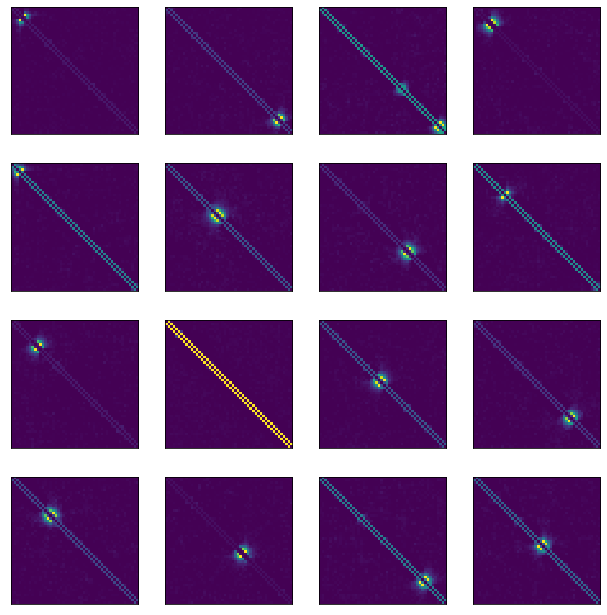

In [96]:
display_dictionary(W, figsize=[10,10])

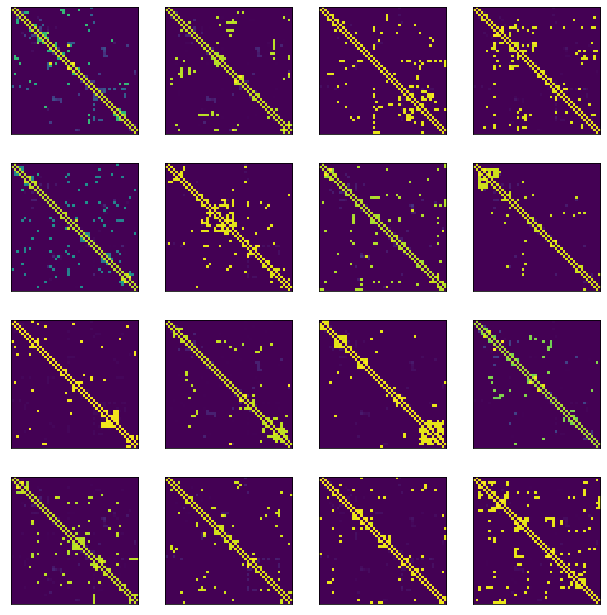

In [90]:
display_dictionary(W_true, figsize=[10,10])

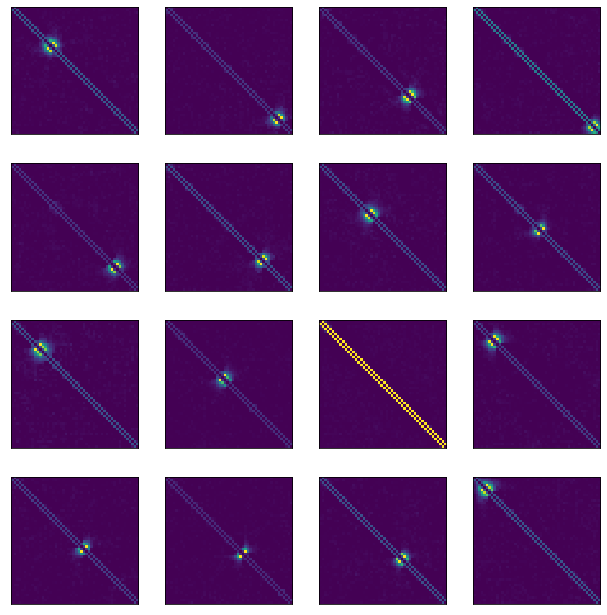

In [91]:
display_dictionary(W_false, figsize=[10,10])

In [92]:
W, H = ALS(X=X.T, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  0%|▏                                   | 4/1000 [00:00<00:56, 17.48it/s]

iteration 0, reconstruction error 394022.517156


  1%|▍                                  | 13/1000 [00:00<00:49, 20.02it/s]

iteration 10, reconstruction error 165540.076154


  2%|▊                                  | 22/1000 [00:01<00:48, 20.24it/s]

iteration 20, reconstruction error 168227.464153


  3%|█▏                                 | 34/1000 [00:01<00:49, 19.41it/s]

iteration 30, reconstruction error 167633.123546


  4%|█▌                                 | 43/1000 [00:02<00:48, 19.73it/s]

iteration 40, reconstruction error 166622.894762


  5%|█▉                                 | 54/1000 [00:02<00:47, 19.91it/s]

iteration 50, reconstruction error 165023.357334


  6%|██▏                                | 63/1000 [00:03<00:46, 20.11it/s]

iteration 60, reconstruction error 162683.977595


  8%|██▋                                | 75/1000 [00:03<00:45, 20.32it/s]

iteration 70, reconstruction error 159297.381514


  8%|██▉                                | 84/1000 [00:04<00:45, 20.27it/s]

iteration 80, reconstruction error 154351.719144


  9%|███▎                               | 93/1000 [00:04<00:46, 19.59it/s]

iteration 90, reconstruction error 147448.445030


 10%|███▌                              | 105/1000 [00:05<00:43, 20.37it/s]

iteration 100, reconstruction error 139234.651077


 11%|███▉                              | 114/1000 [00:05<00:46, 19.06it/s]

iteration 110, reconstruction error 133565.969221


 12%|████▎                             | 125/1000 [00:06<00:43, 19.92it/s]

iteration 120, reconstruction error 131492.213726


 13%|████▌                             | 133/1000 [00:06<00:50, 17.08it/s]

iteration 130, reconstruction error 130380.965362


 14%|████▊                             | 143/1000 [00:07<00:45, 18.83it/s]

iteration 140, reconstruction error 129618.319712


 16%|█████▎                            | 155/1000 [00:07<00:41, 20.29it/s]

iteration 150, reconstruction error 129066.387232


 16%|█████▌                            | 164/1000 [00:08<00:42, 19.71it/s]

iteration 160, reconstruction error 128653.463308


 17%|█████▉                            | 173/1000 [00:08<00:43, 19.22it/s]

iteration 170, reconstruction error 128335.411513


 18%|██████▎                           | 184/1000 [00:09<00:41, 19.87it/s]

iteration 180, reconstruction error 128081.859941


 19%|██████▌                           | 193/1000 [00:09<00:41, 19.30it/s]

iteration 190, reconstruction error 127875.148879


 20%|██████▊                           | 202/1000 [00:10<00:43, 18.45it/s]

iteration 200, reconstruction error 127703.894938


 21%|███████▏                          | 213/1000 [00:10<00:39, 19.94it/s]

iteration 210, reconstruction error 127559.381028


 22%|███████▌                          | 223/1000 [00:11<00:40, 19.06it/s]

iteration 220, reconstruction error 127435.663557


 23%|███████▉                          | 234/1000 [00:12<00:39, 19.18it/s]

iteration 230, reconstruction error 127327.761259


 24%|████████▎                         | 245/1000 [00:12<00:45, 16.41it/s]

iteration 240, reconstruction error 127232.541496


 25%|████████▋                         | 254/1000 [00:13<00:40, 18.40it/s]

iteration 250, reconstruction error 127147.931208


 26%|████████▉                         | 263/1000 [00:13<00:37, 19.54it/s]

iteration 260, reconstruction error 127071.699653


 28%|█████████▎                        | 275/1000 [00:14<00:35, 20.63it/s]

iteration 270, reconstruction error 127002.043873


 28%|█████████▋                        | 284/1000 [00:14<00:35, 20.18it/s]

iteration 280, reconstruction error 126937.282876


 29%|█████████▉                        | 293/1000 [00:15<00:35, 20.06it/s]

iteration 290, reconstruction error 126876.898683


 30%|██████████▎                       | 304/1000 [00:15<00:34, 20.02it/s]

iteration 300, reconstruction error 126819.885670


 31%|██████████▋                       | 314/1000 [00:16<00:36, 18.88it/s]

iteration 310, reconstruction error 126765.657572


 32%|███████████                       | 325/1000 [00:16<00:34, 19.48it/s]

iteration 320, reconstruction error 126713.966632


 33%|███████████▎                      | 333/1000 [00:17<00:34, 19.07it/s]

iteration 330, reconstruction error 126664.652476


 34%|███████████▋                      | 344/1000 [00:17<00:35, 18.63it/s]

iteration 340, reconstruction error 126617.451985


 35%|████████████                      | 353/1000 [00:18<00:34, 18.98it/s]

iteration 350, reconstruction error 126572.142915


 36%|████████████▍                     | 364/1000 [00:18<00:31, 20.26it/s]

iteration 360, reconstruction error 126528.737868


 37%|████████████▋                     | 373/1000 [00:19<00:31, 19.94it/s]

iteration 370, reconstruction error 126487.307772


 38%|█████████████                     | 384/1000 [00:19<00:32, 19.23it/s]

iteration 380, reconstruction error 126447.888505


 39%|█████████████▎                    | 393/1000 [00:20<00:31, 19.29it/s]

iteration 390, reconstruction error 126410.718072


 40%|█████████████▊                    | 405/1000 [00:20<00:31, 19.18it/s]

iteration 400, reconstruction error 126375.888928


 41%|██████████████                    | 413/1000 [00:21<00:31, 18.57it/s]

iteration 410, reconstruction error 126343.505575


 42%|██████████████▍                   | 423/1000 [00:21<00:32, 17.77it/s]

iteration 420, reconstruction error 126313.342808


 43%|██████████████▋                   | 433/1000 [00:22<00:29, 18.90it/s]

iteration 430, reconstruction error 126285.366876


 44%|███████████████                   | 443/1000 [00:22<00:29, 18.99it/s]

iteration 440, reconstruction error 126259.613372


 45%|███████████████▍                  | 454/1000 [00:23<00:28, 19.33it/s]

iteration 450, reconstruction error 126235.936948


 46%|███████████████▋                  | 463/1000 [00:23<00:28, 19.14it/s]

iteration 460, reconstruction error 126214.255997


 47%|████████████████                  | 474/1000 [00:24<00:27, 19.42it/s]

iteration 470, reconstruction error 126194.351825


 48%|████████████████▍                 | 484/1000 [00:24<00:25, 20.30it/s]

iteration 480, reconstruction error 126176.070423


 49%|████████████████▊                 | 494/1000 [00:25<00:27, 18.34it/s]

iteration 490, reconstruction error 126159.254073


 50%|█████████████████▏                | 504/1000 [00:26<00:26, 19.06it/s]

iteration 500, reconstruction error 126143.762300


 51%|█████████████████▍                | 513/1000 [00:26<00:27, 17.40it/s]

iteration 510, reconstruction error 126129.466027


 52%|█████████████████▊                | 524/1000 [00:27<00:26, 18.28it/s]

iteration 520, reconstruction error 126116.362902


 53%|██████████████████                | 533/1000 [00:27<00:25, 18.27it/s]

iteration 530, reconstruction error 126104.324756


 54%|██████████████████▍               | 543/1000 [00:28<00:23, 19.39it/s]

iteration 540, reconstruction error 126093.189535


 55%|██████████████████▊               | 554/1000 [00:28<00:21, 20.28it/s]

iteration 550, reconstruction error 126082.843662


 56%|███████████████████▏              | 563/1000 [00:29<00:23, 18.42it/s]

iteration 560, reconstruction error 126073.210099


 57%|███████████████████▌              | 574/1000 [00:29<00:22, 19.03it/s]

iteration 570, reconstruction error 126064.231046


 58%|███████████████████▊              | 583/1000 [00:30<00:22, 18.84it/s]

iteration 580, reconstruction error 126055.839064


 60%|████████████████████▏             | 595/1000 [00:30<00:20, 19.38it/s]

iteration 590, reconstruction error 126047.980157


 60%|████████████████████▌             | 604/1000 [00:31<00:20, 19.17it/s]

iteration 600, reconstruction error 126040.630769


 61%|████████████████████▊             | 613/1000 [00:31<00:20, 18.77it/s]

iteration 610, reconstruction error 126033.736373


 62%|█████████████████████▏            | 623/1000 [00:32<00:20, 18.46it/s]

iteration 620, reconstruction error 126027.251902


 63%|█████████████████████▌            | 633/1000 [00:32<00:19, 18.48it/s]

iteration 630, reconstruction error 126021.145222


 64%|█████████████████████▊            | 643/1000 [00:33<00:18, 18.83it/s]

iteration 640, reconstruction error 126015.381998


 65%|██████████████████████▏           | 654/1000 [00:33<00:17, 19.58it/s]

iteration 650, reconstruction error 126009.927185


 66%|██████████████████████▌           | 663/1000 [00:34<00:16, 20.19it/s]

iteration 660, reconstruction error 126004.751642


 67%|██████████████████████▉           | 674/1000 [00:34<00:16, 19.26it/s]

iteration 670, reconstruction error 125999.828873


 68%|███████████████████████▎          | 684/1000 [00:35<00:16, 18.96it/s]

iteration 680, reconstruction error 125995.138773


 69%|███████████████████████▌          | 694/1000 [00:36<00:16, 18.98it/s]

iteration 690, reconstruction error 125990.671410


 70%|███████████████████████▉          | 704/1000 [00:36<00:15, 18.69it/s]

iteration 700, reconstruction error 125986.396989


 71%|████████████████████████▏         | 713/1000 [00:37<00:15, 18.04it/s]

iteration 710, reconstruction error 125982.298519


 72%|████████████████████████▌         | 724/1000 [00:37<00:14, 18.60it/s]

iteration 720, reconstruction error 125978.356321


 73%|████████████████████████▉         | 733/1000 [00:38<00:15, 17.42it/s]

iteration 730, reconstruction error 125974.552009


 74%|█████████████████████████▎        | 743/1000 [00:38<00:14, 18.25it/s]

iteration 740, reconstruction error 125970.874010


 75%|█████████████████████████▋        | 754/1000 [00:39<00:14, 17.49it/s]

iteration 750, reconstruction error 125967.317658


 76%|█████████████████████████▉        | 764/1000 [00:39<00:14, 16.54it/s]

iteration 760, reconstruction error 125963.867881


 77%|██████████████████████████▎       | 773/1000 [00:40<00:12, 17.73it/s]

iteration 770, reconstruction error 125960.514679


 78%|██████████████████████████▋       | 785/1000 [00:41<00:10, 20.22it/s]

iteration 780, reconstruction error 125957.251748


 80%|███████████████████████████       | 795/1000 [00:41<00:10, 19.28it/s]

iteration 790, reconstruction error 125954.072917


 80%|███████████████████████████▎      | 803/1000 [00:42<00:10, 18.01it/s]

iteration 800, reconstruction error 125950.974541


 81%|███████████████████████████▋      | 813/1000 [00:42<00:09, 18.90it/s]

iteration 810, reconstruction error 125947.953008


 82%|████████████████████████████      | 824/1000 [00:43<00:09, 18.96it/s]

iteration 820, reconstruction error 125945.003280


 83%|████████████████████████████▎     | 833/1000 [00:43<00:09, 17.87it/s]

iteration 830, reconstruction error 125942.124048


 84%|████████████████████████████▋     | 842/1000 [00:44<00:09, 16.88it/s]

iteration 840, reconstruction error 125939.323659


 85%|█████████████████████████████     | 853/1000 [00:44<00:08, 18.21it/s]

iteration 850, reconstruction error 125936.596628


 86%|█████████████████████████████▍    | 864/1000 [00:45<00:07, 18.08it/s]

iteration 860, reconstruction error 125933.941481


 87%|█████████████████████████████▋    | 874/1000 [00:45<00:06, 19.03it/s]

iteration 870, reconstruction error 125931.358041


 88%|██████████████████████████████    | 883/1000 [00:46<00:06, 18.78it/s]

iteration 880, reconstruction error 125928.847562


 89%|██████████████████████████████▍   | 894/1000 [00:47<00:05, 17.82it/s]

iteration 890, reconstruction error 125926.408549


 90%|██████████████████████████████▋   | 903/1000 [00:47<00:06, 16.04it/s]

iteration 900, reconstruction error 125924.042685


 91%|███████████████████████████████   | 914/1000 [00:48<00:04, 17.57it/s]

iteration 910, reconstruction error 125921.753495


 92%|███████████████████████████████▍  | 924/1000 [00:48<00:04, 17.60it/s]

iteration 920, reconstruction error 125919.542487


 93%|███████████████████████████████▋  | 933/1000 [00:49<00:03, 18.25it/s]

iteration 930, reconstruction error 125917.407145


 94%|████████████████████████████████  | 943/1000 [00:49<00:03, 17.06it/s]

iteration 940, reconstruction error 125915.349167


 95%|████████████████████████████████▍ | 954/1000 [00:50<00:02, 18.57it/s]

iteration 950, reconstruction error 125913.368581


 96%|████████████████████████████████▊ | 964/1000 [00:51<00:01, 18.76it/s]

iteration 960, reconstruction error 125911.467316


 97%|█████████████████████████████████ | 973/1000 [00:51<00:01, 17.57it/s]

iteration 970, reconstruction error 125909.648762


 98%|█████████████████████████████████▍| 984/1000 [00:52<00:00, 18.73it/s]

iteration 980, reconstruction error 125907.909866


 99%|█████████████████████████████████▊| 994/1000 [00:52<00:00, 18.88it/s]

iteration 990, reconstruction error 125906.250596


100%|█████████████████████████████████| 1000/1000 [00:52<00:00, 18.88it/s]


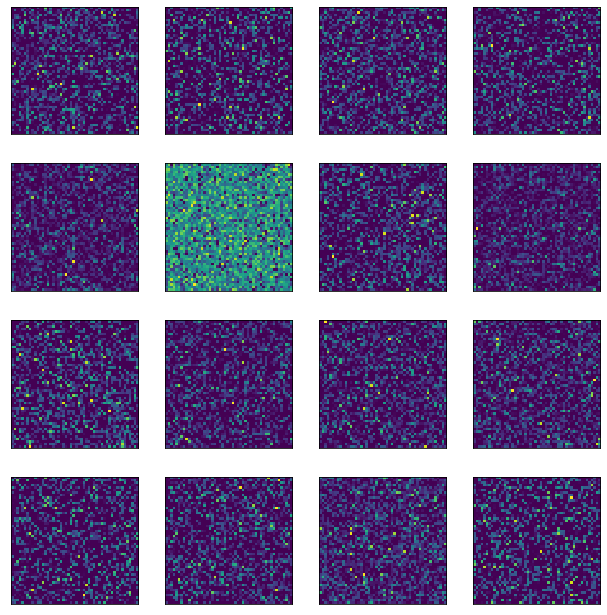

In [93]:
display_dictionary(W, figsize=[10,10])